Importing libraries

In [1]:
import numpy as np
import pandas as pd

# Pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from tensorflow.keras.utils import to_categorical
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artkh.000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Importing dataset

In [2]:
data = pd.read_csv('image_data.csv')

Check the dataset

In [3]:
data.head()

,path_to_image,Benign or Malignant,Cancer Type,Magnification
0,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
1,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
2,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
3,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
4,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   path_to_image        7909 non-null   object
 1   Benign or Malignant  7906 non-null   object
 2   Cancer Type          7905 non-null   object
 3   Magnification        7905 non-null   object
dtypes: object(4)
memory usage: 247.3+ KB


Clean dataset from null values

In [5]:
data_cleaned = data.dropna(subset=['Benign or Malignant', 'Cancer Type'])

In [6]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7908
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   path_to_image        7905 non-null   object
 1   Benign or Malignant  7905 non-null   object
 2   Cancer Type          7905 non-null   object
 3   Magnification        7905 non-null   object
dtypes: object(4)
memory usage: 308.8+ KB


Loading and preprocessing images

In [7]:
image_paths = data_cleaned['path_to_image']

In [8]:
def load_and_preprocess_images(image_paths, target_size = (244,244)):
    images = []
    
    for i, path in enumerate(image_paths):
        #print(f"Обрабатывается путь {i + 1}/{len(image_paths)}: {path}")

        # Load image
        image = cv2.imread(path)
        
        # Resize image to target size
        h, w = image.shape[:2]
        scale = min(target_size[0] / h, target_size[1] / w)
        new_size = (int(w * scale), int(h * scale))
        resized_image = cv2.resize(image, new_size)

        # Normalize pixel values to [0, 1]
        resized_image = resized_image / 255.0
        images.append(resized_image)
        #print(f"Путь обработан {i + 1}/{len(image_paths)}: {path}")
    
    return images


In [9]:
data_cleaned['images'] = load_and_preprocess_images(image_paths)

C:\Users\artkh.000\AppData\Local\Temp\ipykernel_27612\2647882338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['images'] = load_and_preprocess_images(image_paths)


In [10]:
data_cleaned = data_cleaned.drop(columns = ['path_to_image','Magnification'])

In [11]:
data_cleaned['Benign or Malignant'] = data_cleaned['Benign or Malignant'].map({'Benign': 0, 'Malignant': 1})
data_cleaned['Cancer Type'] = data_cleaned['Cancer Type'].astype('category').cat.codes

    Part1 - Binary

In [12]:
# Split for binary classification
X_train_binary, X_val_binary, y_train_binary, y_val_binary = train_test_split(
    data_cleaned['images'], data_cleaned['Benign or Malignant'], test_size=0.2, random_state=42, stratify=data_cleaned['Benign or Malignant'])

Part2 - Multiclass

In [13]:
# Split for multiclass classification
X_train_multiclass, X_val_multiclass, y_train_multiclass, y_val_multiclass = train_test_split(
    data_cleaned['images'], data_cleaned['Cancer Type'], test_size=0.2, random_state=42, stratify=data_cleaned['Cancer Type'])

# Convert labels to categorical
y_train_multiclass = to_categorical(y_train_multiclass, num_classes=8)
y_val_multiclass = to_categorical(y_val_multiclass, num_classes=8)

1. Model Design

Define a Convolutional Neural Network (CNN) architecture to classify the images into binary classes (Benign or Malignant).

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN model
def create_binary_classification_model(input_shape):
    model = Sequential()
    
    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example: Assuming images are resized to 224x224 and have 3 channels (RGB)
input_shape = (224, 224, 3)
binary_model = create_binary_classification_model(input_shape)

# Print model summary
binary_model.summary()


C:\Users\artkh.000\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Check the shape of each image in the dataset
image_shapes = [img.shape for img in X_train_binary]

# Print unique shapes
unique_shapes = set(image_shapes)
print(f"Unique image shapes in training data: {unique_shapes}")


Unique image shapes in training data: {(160, 244, 3), (158, 244, 3)}


In [16]:
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.image import resize

def resize_images(image_list, target_size=(224, 224)):
    resized_images = []
    for img in image_list:
        # Convert NumPy array to a PIL image and resize
        img_resized = resize(img, target_size)  # Resize to target dimensions
        resized_images.append(img_to_array(img_resized))
    return np.array(resized_images, dtype=np.float32)

# Resize training and validation images
X_train_binary_resized = resize_images(X_train_binary, target_size=(224, 224))
X_val_binary_resized = resize_images(X_val_binary, target_size=(224, 224))

# Normalize pixel values to [0, 1]
X_train_binary_resized /= 255.0
X_val_binary_resized /= 255.0

# Check final shapes
print(f"Resized training data shape: {X_train_binary_resized.shape}")
print(f"Resized validation data shape: {X_val_binary_resized.shape}")


Resized training data shape: (6324, 224, 224, 3)
Resized validation data shape: (1581, 224, 224, 3)


2. Training and Validation Data Preparation

Convert image arrays and labels into NumPy arrays suitable for TensorFlow/Keras.

Training data shape: (6324, 224, 224, 3)
Validation data shape: (1581, 224, 224, 3)
Training labels shape: (6324,)
Validation labels shape: (1581,)


2.1. Debugging the Data

Inspect X_train_binary to identify inconsistencies:

In [17]:
# Check the first few elements to understand their structure
print(f"Type of X_train_binary: {type(X_train_binary)}")
print(f"Length of X_train_binary: {len(X_train_binary)}")
print(f"Type of first element: {type(X_train_binary[0])}")

# Check shapes of individual images
shapes = [np.array(img).shape if isinstance(img, (np.ndarray, list)) else None for img in X_train_binary]
unique_shapes = set(shapes)
print(f"Unique shapes: {unique_shapes}")


Type of X_train_binary: <class 'pandas.core.series.Series'>
Length of X_train_binary: 6324
Type of first element: <class 'numpy.ndarray'>


Unique shapes: {(160, 244, 3), (158, 244, 3)}


2.2. Uniformly Load and Resize Images

Use this function to handle resizing and uniform formatting:

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize

def preprocess_images(image_list, target_size=(224, 224)):
    processed_images = []
    for img in image_list:
        if isinstance(img, str):  # If the image is a file path
            img = load_img(img, target_size=target_size)  # Load and resize
            img = img_to_array(img)
        elif isinstance(img, np.ndarray):  # If already an array
            img = resize(img, target_size)  # Resize using TensorFlow
        else:
            raise ValueError("Unexpected data format in image list.")
        processed_images.append(img)
    return np.array(processed_images, dtype=np.float32)

# Apply preprocessing to training and validation sets
X_train_binary = preprocess_images(X_train_binary, target_size=(224, 224))
X_val_binary = preprocess_images(X_val_binary, target_size=(224, 224))


2.3. Normalize Data

Normalize pixel values to [0, 1]:

In [19]:
X_train_binary /= 255.0
X_val_binary /= 255.0


2.4. Verify Final Shapes

Confirm that all data is now consistent:

In [20]:
print(f"Training data shape: {X_train_binary.shape}")
print(f"Validation data shape: {X_val_binary.shape}")


Training data shape: (6324, 224, 224, 3)
Validation data shape: (1581, 224, 224, 3)


In [ ]:
import numpy as np

# Convert images to consistent NumPy arrays
def preprocess_images(image_list):
    # Resize all images to the same dimensions (224x224x3) and normalize
    processed_images = [np.array(img, dtype=np.float32) for img in image_list]
    return np.array(processed_images)

# Apply preprocessing to training and validation sets
X_train_binary = preprocess_images(X_train_binary)
X_val_binary = preprocess_images(X_val_binary)

# Convert labels to NumPy arrays
y_train_binary = np.array(y_train_binary, dtype=np.int32)
y_val_binary = np.array(y_val_binary, dtype=np.int32)

# Check shapes
print(f"Training data shape: {X_train_binary.shape}")
print(f"Validation data shape: {X_val_binary.shape}")
print(f"Training labels shape: {y_train_binary.shape}")
print(f"Validation labels shape: {y_val_binary.shape}")

3. Model Training

Compile and train the CNN using the training data and validate it with the validation data.

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = binary_model.fit(
    X_train_binary,
    y_train_binary,
    validation_data=(X_val_binary, y_val_binary),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save the trained model
binary_model.save('binary_classification_model.h5')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 114s 543ms/step - accuracy: 0.6574 - loss: 0.6458 - val_accuracy: 0.6863 - val_loss: 0.6250
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 129s 652ms/step - accuracy: 0.6901 - loss: 0.6237 - val_accuracy: 0.6863 - val_loss: 0.6235
Epoch 3/20
 96/198 ━━━━━━━━━━━━━━━━━━━━ 1:02 612ms/step - accuracy: 0.6809 - loss: 0.6301

KeyboardInterrupt: 

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step
AUC Score: 0.5000
Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       496
   Malignant       0.69      1.00      0.81      1085

    accuracy                           0.69      1581
   macro avg       0.34      0.50      0.41      1581
weighted avg       0.47      0.69      0.56      1581



C:\Users\artkh.000\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\artkh.000\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\artkh.000\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

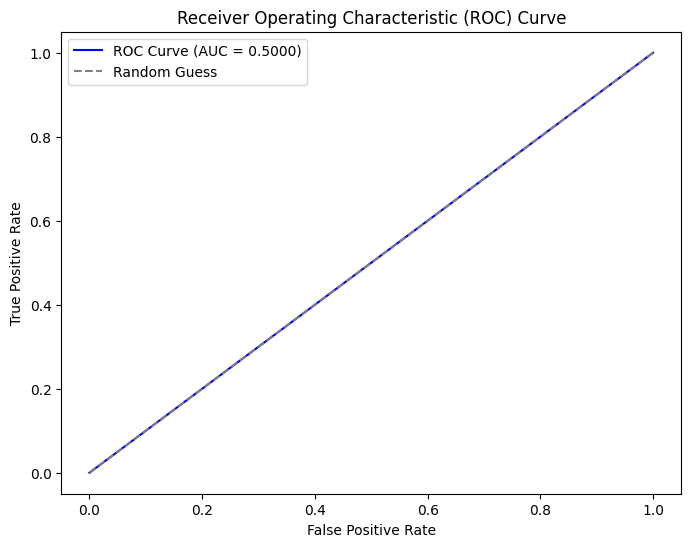

In [33]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Predict probabilities and convert to binary predictions
y_pred_probs = binary_model.predict(X_val_binary)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Calculate AUC
auc_score = roc_auc_score(y_val_binary, y_pred_probs)
print(f"AUC Score: {auc_score:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_val_binary, y_pred_binary, target_names=['Benign', 'Malignant']))

# Plot ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val_binary, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

part2

Multiclass Classification
Data Preparation:

In [22]:
# Reloading the dataset
data_file_path = 'image_data.csv'
data = pd.read_csv(data_file_path)

# Cleaning the data to drop missing values in relevant columns
data_cleaned = data.dropna(subset=['Benign or Malignant', 'Cancer Type'])

# One-hot encoding the target labels (Cancer Type)
target = pd.get_dummies(data_cleaned['Cancer Type'], prefix='CancerType')

# Splitting data into training, validation, and test sets
from sklearn.model_selection import train_test_split

image_paths = data_cleaned['path_to_image'].values  # Image file paths
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, target.values, test_size=0.2, random_state=42, stratify=target.values
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Displaying basic statistics for confirmation
print(f"Train samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")


Train samples: 5059
Validation samples: 1265
Test samples: 1581


Data Augmentation:

Apply augmentation techniques (rotation, flipping, zooming) to handle class imbalance or enhance model generalization.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,        # Normalize pixel values to [0, 1]
    rotation_range=40,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Horizontal flipping
    fill_mode='nearest'       # Fill empty pixels after transformation
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescaling for testing

# Prepare data for generators (convert numeric labels to string format)
def prepare_dataframe(image_paths, labels):
    return pd.DataFrame({
        'filename': image_paths,
        'class': labels.argmax(axis=1).astype(str)  # Convert numeric labels to string
    })

train_df = prepare_dataframe(train_paths, train_labels)
val_df = prepare_dataframe(val_paths, val_labels)
test_df = prepare_dataframe(test_paths, test_labels)

# Create image generators
def create_image_generators(dataframes, batch_size=32, target_size=(150, 150)):
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=dataframes['train'],
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=dataframes['val'],
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=dataframes['test'],
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator, val_generator, test_generator

# Pass dataframes for training, validation, and test
dataframes = {'train': train_df, 'val': val_df, 'test': test_df}
batch_size = 32
target_size = (150, 150)
train_generator, val_generator, test_generator = create_image_generators(dataframes, batch_size, target_size)



Found 5059 validated image filenames belonging to 8 classes.
Found 1265 validated image filenames belonging to 8 classes.
Found 1581 validated image filenames belonging to 8 classes.


Model Definition:

Define a Convolutional Neural Network (CNN) suitable for multiclass image classification.
Include layers such as Conv2D, MaxPooling2D, Flatten, Dense, and Dropout.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Fully Connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))  # Softmax for multiclass classification

    return model

# Define input shape and number of classes
input_shape = (150, 150, 3)  # Image dimensions (150x150) with 3 channels (RGB)
num_classes = train_labels.shape[1]  # Number of unique classes (from one-hot encoding)

# Create the model
cnn_model = create_cnn_model(input_shape, num_classes)

# Summary of the model
cnn_model.summary()


C:\Users\artkh.000\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,384 (18.42 MB)

 Trainable params: 4,829,384 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Model Compilation:

Use a categorical cross-entropy loss function for multiclass classification.
Choose an optimizer (e.g., Adam) and track accuracy as the evaluation metric.

In [30]:
from tensorflow.keras.optimizers import Adam

# Compile the CNN model
# def compile_cnn_model(model, learning_rate=0.001):
#     model.compile(
#         optimizer=Adam(learning_rate=learning_rate),  # Adam optimizer with a default learning rate
#         loss='categorical_crossentropy',             # Loss function for multiclass classification
#         metrics=['accuracy']                         # Track accuracy during training
#     )

from tensorflow.keras.metrics import Precision, Recall

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[Precision(), Recall()]  # Add precision and recall
)


# Compile the model
compile_cnn_model(cnn_model)

# Summary of the compiled model
cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,384 (18.42 MB)

 Trainable params: 4,829,384 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")


Class weights: {0: 2.2266725352112675, 1: 0.28640172101449274, 2: 0.9743836671802774, 3: 1.576995012468828, 4: 1.2522277227722771, 5: 1.7664106145251397, 6: 2.1806034482758623, 7: 1.737293956043956}


Model Training:

Train the model on the training set using appropriate callbacks (e.g., EarlyStopping).
Evaluate the performance on the validation set during training.

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=5,                 # Stop if no improvement for 5 epochs
    restore_best_weights=True   # Restore model weights from the epoch with the best validation loss
)

model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.keras',  # Save the best model with the correct extension
    monitor='val_loss',              # Monitor validation loss
    save_best_only=True              # Save only the best weights
)

# Train the model
history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,                   # Specify the maximum number of epochs
    callbacks=[early_stopping, model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Evaluate the model on the validation set
val_loss, val_accuracy = cnn_model.evaluate(val_generator, steps=len(val_generator))
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 153s 950ms/step - accuracy: 0.4190 - loss: 1.9855 - val_accuracy: 0.4569 - val_loss: 1.6198
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 140s 880ms/step - accuracy: 0.4815 - loss: 1.6495 - val_accuracy: 0.4988 - val_loss: 1.5311
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 137s 860ms/step - accuracy: 0.4999 - loss: 1.5817 - val_accuracy: 0.4941 - val_loss: 1.4992
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 138s 867ms/step - accuracy: 0.4897 - loss: 1.5642 - val_accuracy: 0.4648 - val_loss: 1.5608
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 136s 852ms/step - accuracy: 0.5026 - loss: 1.5125 - val_accuracy: 0.5194 - val_loss: 1.4190
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 149s 937ms/step - accuracy: 0.4958 - loss: 1.5307 - val_accuracy: 0.5154 - val_loss: 1.3787
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 134s 843ms/step - accuracy: 0.5181 - loss: 1.4787 - val_accuracy: 0.5146 - val_loss: 1.4445
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 131s 825ms/step - accuracy: 0.5144 -

Testing and Evaluation:

Evaluate the final model on the test set and report metrics such as accuracy, precision, recall, and confusion matrix.

50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.5268 - loss: 1.2892
Test Loss: 1.2523
Test Accuracy: 0.5509
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 476ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.29      0.37        89
           1       0.64      0.94      0.76       690
           2       0.33      0.66      0.44       203
           3       0.79      0.18      0.30       125
           4       0.33      0.01      0.01       158
           5       0.00      0.00      0.00       112
           6       0.00      0.00      0.00        90
           7       0.51      0.32      0.40       114

    accuracy                           0.55      1581
   macro avg       0.39      0.30      0.29      1581
weighted avg       0.48      0.55      0.46      1581



C:\Users\artkh.000\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\artkh.000\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\artkh.000\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

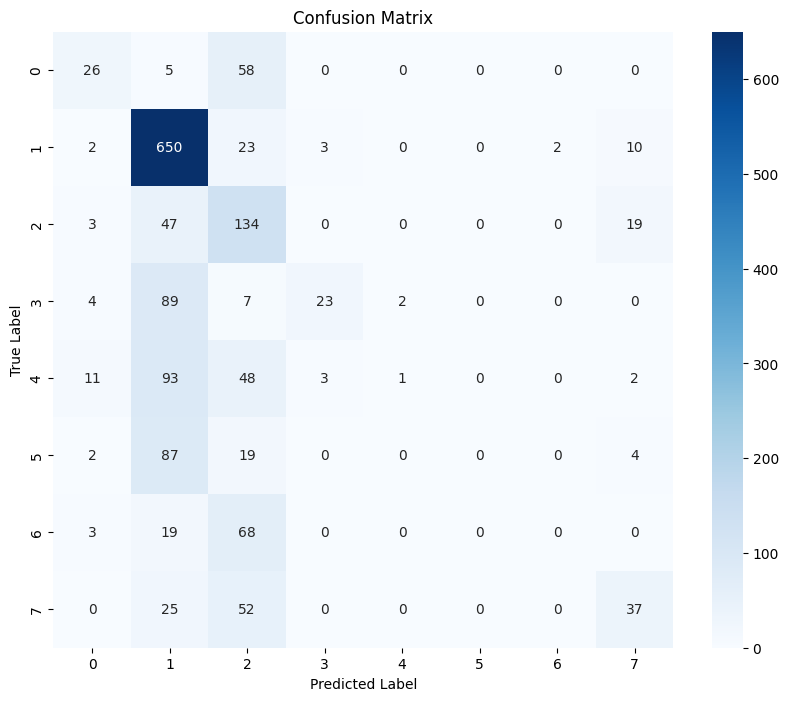

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
test_generator.reset()  # Reset the generator before predictions
predictions = cnn_model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)  # Predicted class indices
true_classes = test_generator.classes  # True class indices

# Classification report
class_labels = list(test_generator.class_indices.keys())  # Get class labels
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Visualization:

Plot the training and validation loss and accuracy.
Display a confusion matrix for the test set predictions.

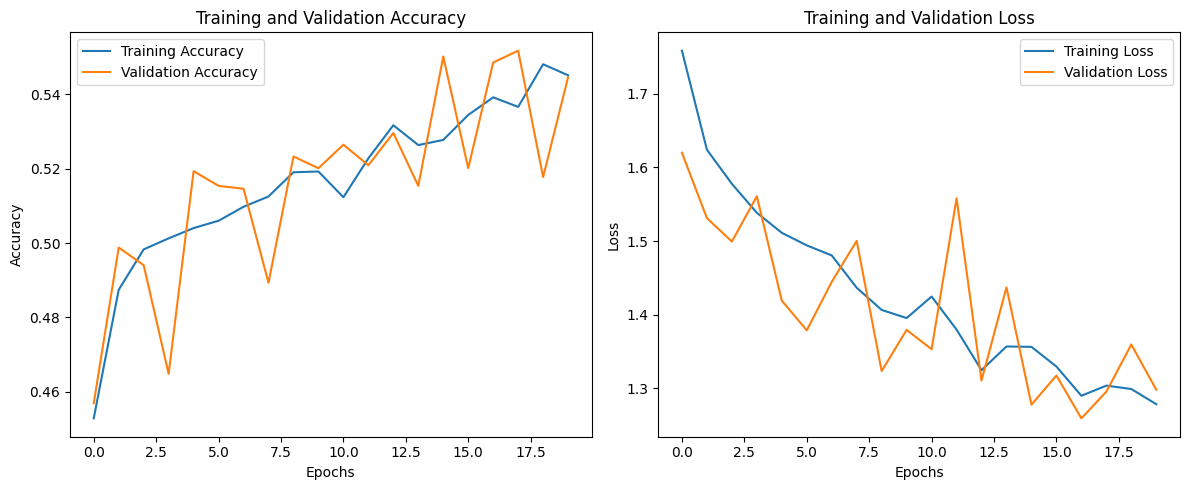

In [37]:
# Plot training and validation loss and accuracy
def plot_training_history(history):
    # Extract metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


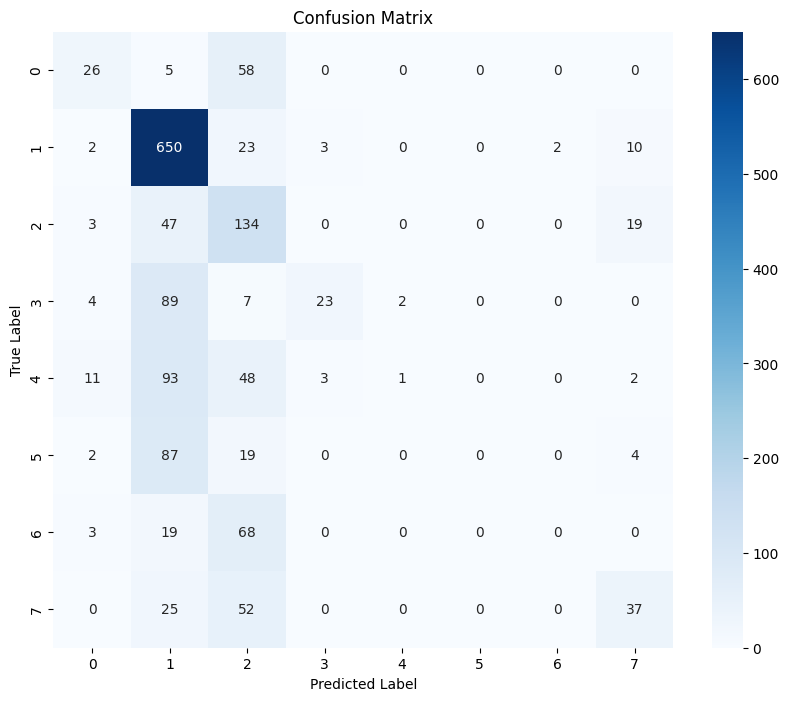

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Call the function
class_labels = list(test_generator.class_indices.keys())  # Get class labels
plot_confusion_matrix(conf_matrix, class_labels)


Saving and Loading the Model:

Save the trained model for future inference.
Include code to load the model and predict new samples.

In [34]:
# Save the trained model
cnn_model.save('breast_cancer_classifier.keras')
print("Model saved successfully!")


Model saved successfully!


In [35]:
from tensorflow.keras.models import load_model

# Load the saved model
saved_model = load_model('breast_cancer_classifier.keras')
print("Model loaded successfully!")


Model loaded successfully!


In [36]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to preprocess and predict a single image
def predict_sample(model, image_path, target_size=(150, 150)):
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)  # Resize the image
    img_array = img_to_array(img) / 255.0              # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)      # Add batch dimension

    # Predict the class probabilities
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class index
    class_labels = list(test_generator.class_indices.keys())  # Map index to label

    return class_labels[predicted_class], predictions[0]  # Return class label and probabilities

# Example usage
image_path = 'path_to_new_image.jpg'  # Replace with the path to your test image
predicted_class, probabilities = predict_sample(saved_model, image_path)
print(f"Predicted Class: {predicted_class}")
print(f"Class Probabilities: {probabilities}")


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_new_image.jpg'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your train data is in a directory structure with subfolders for each class
# Extract the class indices for train_generator (which corresponds to the labels)
class_counts = pd.Series(train_generator.classes).value_counts()
class_labels = [key for key, value in train_generator.class_indices.items()]

# Plot class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45, ha='right')
plt.title("Class Distribution in Training Data")
plt.xlabel("Cancer Types")
plt.ylabel("Number of Samples")
plt.show()

# Print the class counts
print("Class Distribution in Training Set:")
for label, count in zip(class_labels, class_counts):
    print(f"{label}: {count} samples")



NameError: name 'train_generator' is not defined